In [ ]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [ ]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_bas_data_nor_b10_b25_b50_b75_roi_t1_mask_t1_nat_k5_b25_k7_b25_k9_b25_k11_b25_t1_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 1132)
(878801, 3)
validation
(151459, 1132)
(151459, 3)
test
(112754, 1132)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1132)]            0         


 dense (Dense)               (None, 2048)              2320384   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 5107971 (19.49 MB)


Trainable params: 5107971 (19.49 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:34 - loss: 1.6285 - STD: 0.3297 - MAE: 0.4385

2/9 [=====>........................] - ETA: 3s - loss: 1.4057 - STD: 0.2416 - MAE: 0.4398  

3/9 [=========>....................] - ETA: 2s - loss: 1.2959 - STD: 0.1783 - MAE: 0.4388

4/9 [============>.................] - ETA: 2s - loss: 1.2525 - STD: 0.1694 - MAE: 0.4366

5/9 [===============>..............] - ETA: 9s - loss: 1.2384 - STD: 0.1722 - MAE: 0.4344

6/9 [===================>..........] - ETA: 5s - loss: 1.2284 - STD: 0.1743 - MAE: 0.4332

7/9 [======================>.......] - ETA: 3s - loss: 1.2180 - STD: 0.1731 - MAE: 0.4326

8/9 [=========================>....] - ETA: 1s - loss: 1.2069 - STD: 0.1684 - MAE: 0.4326

9/9 [==============================] - ETA: 0s - loss: 1.1954 - STD: 0.1612 - MAE: 0.4328

9/9 [==============================] - 28s 2s/step - loss: 1.1954 - STD: 0.1612 - MAE: 0.4328 - val_loss: 1.0866 - val_STD: 0.0734 - val_MAE: 0.4364


Epoch 2/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0862 - STD: 0.0734 - MAE: 0.4363

2/9 [=====>........................] - ETA: 4s - loss: 1.0808 - STD: 0.0651 - MAE: 0.4363

3/9 [=========>....................] - ETA: 3s - loss: 1.0796 - STD: 0.0650 - MAE: 0.4361

4/9 [============>.................] - ETA: 2s - loss: 1.0815 - STD: 0.0699 - MAE: 0.4359

5/9 [===============>..............] - ETA: 1s - loss: 1.0844 - STD: 0.0763 - MAE: 0.4356

6/9 [===================>..........] - ETA: 1s - loss: 1.0871 - STD: 0.0819 - MAE: 0.4353

7/9 [======================>.......] - ETA: 0s - loss: 1.0892 - STD: 0.0859 - MAE: 0.4351

8/9 [=========================>....] - ETA: 0s - loss: 1.0900 - STD: 0.0880 - MAE: 0.4350

9/9 [==============================] - ETA: 0s - loss: 1.0898 - STD: 0.0883 - MAE: 0.4349

9/9 [==============================] - 6s 588ms/step - loss: 1.0898 - STD: 0.0883 - MAE: 0.4349 - val_loss: 1.0791 - val_STD: 0.0774 - val_MAE: 0.4345


Epoch 3/10000


1/9 [==>...........................] - ETA: 7s - loss: 1.0797 - STD: 0.0774 - MAE: 0.4347

2/9 [=====>........................] - ETA: 3s - loss: 1.0779 - STD: 0.0726 - MAE: 0.4349

3/9 [=========>....................] - ETA: 3s - loss: 1.0771 - STD: 0.0699 - MAE: 0.4350

4/9 [============>.................] - ETA: 2s - loss: 1.0767 - STD: 0.0694 - MAE: 0.4350

5/9 [===============>..............] - ETA: 2s - loss: 1.0770 - STD: 0.0705 - MAE: 0.4349

6/9 [===================>..........] - ETA: 1s - loss: 1.0777 - STD: 0.0726 - MAE: 0.4347

7/9 [======================>.......] - ETA: 1s - loss: 1.0784 - STD: 0.0750 - MAE: 0.4345

8/9 [=========================>....] - ETA: 0s - loss: 1.0789 - STD: 0.0773 - MAE: 0.4343

9/9 [==============================] - ETA: 0s - loss: 1.0793 - STD: 0.0792 - MAE: 0.4341

9/9 [==============================] - 6s 576ms/step - loss: 1.0793 - STD: 0.0792 - MAE: 0.4341 - val_loss: 1.0805 - val_STD: 0.0916 - val_MAE: 0.4325


Epoch 4/10000


1/9 [==>...........................] - ETA: 7s - loss: 1.0795 - STD: 0.0916 - MAE: 0.4322

2/9 [=====>........................] - ETA: 3s - loss: 1.0786 - STD: 0.0892 - MAE: 0.4324

3/9 [=========>....................] - ETA: 2s - loss: 1.0771 - STD: 0.0864 - MAE: 0.4325

4/9 [============>.................] - ETA: 2s - loss: 1.0765 - STD: 0.0836 - MAE: 0.4328

5/9 [===============>..............] - ETA: 1s - loss: 1.0760 - STD: 0.0812 - MAE: 0.4330

6/9 [===================>..........] - ETA: 1s - loss: 1.0759 - STD: 0.0792 - MAE: 0.4333

7/9 [======================>.......] - ETA: 0s - loss: 1.0758 - STD: 0.0777 - MAE: 0.4335

8/9 [=========================>....] - ETA: 0s - loss: 1.0759 - STD: 0.0767 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0761 - STD: 0.0760 - MAE: 0.4339

9/9 [==============================] - 6s 580ms/step - loss: 1.0761 - STD: 0.0760 - MAE: 0.4339 - val_loss: 1.0761 - val_STD: 0.0715 - val_MAE: 0.4347


Epoch 5/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0770 - STD: 0.0715 - MAE: 0.4348

2/9 [=====>........................] - ETA: 4s - loss: 1.0764 - STD: 0.0718 - MAE: 0.4347

3/9 [=========>....................] - ETA: 3s - loss: 1.0758 - STD: 0.0721 - MAE: 0.4345

4/9 [============>.................] - ETA: 2s - loss: 1.0755 - STD: 0.0725 - MAE: 0.4343

5/9 [===============>..............] - ETA: 2s - loss: 1.0752 - STD: 0.0729 - MAE: 0.4342

6/9 [===================>..........] - ETA: 1s - loss: 1.0750 - STD: 0.0734 - MAE: 0.4341

7/9 [======================>.......] - ETA: 1s - loss: 1.0749 - STD: 0.0738 - MAE: 0.4340

8/9 [=========================>....] - ETA: 0s - loss: 1.0749 - STD: 0.0741 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0751 - STD: 0.0743 - MAE: 0.4339

9/9 [==============================] - 6s 651ms/step - loss: 1.0751 - STD: 0.0743 - MAE: 0.4339 - val_loss: 1.0754 - val_STD: 0.0748 - val_MAE: 0.4340


Epoch 6/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0744 - STD: 0.0748 - MAE: 0.4337

2/9 [=====>........................] - ETA: 3s - loss: 1.0744 - STD: 0.0744 - MAE: 0.4338

3/9 [=========>....................] - ETA: 2s - loss: 1.0746 - STD: 0.0742 - MAE: 0.4338

4/9 [============>.................] - ETA: 2s - loss: 1.0747 - STD: 0.0741 - MAE: 0.4339

5/9 [===============>..............] - ETA: 2s - loss: 1.0747 - STD: 0.0740 - MAE: 0.4339

6/9 [===================>..........] - ETA: 1s - loss: 1.0746 - STD: 0.0738 - MAE: 0.4339

7/9 [======================>.......] - ETA: 0s - loss: 1.0746 - STD: 0.0737 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0746 - STD: 0.0736 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0745 - STD: 0.0735 - MAE: 0.4339

9/9 [==============================] - 6s 627ms/step - loss: 1.0745 - STD: 0.0735 - MAE: 0.4339 - val_loss: 1.0739 - val_STD: 0.0718 - val_MAE: 0.4341


Epoch 7/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0748 - STD: 0.0718 - MAE: 0.4342

2/9 [=====>........................] - ETA: 4s - loss: 1.0743 - STD: 0.0715 - MAE: 0.4342

3/9 [=========>....................] - ETA: 3s - loss: 1.0742 - STD: 0.0713 - MAE: 0.4342

4/9 [============>.................] - ETA: 2s - loss: 1.0744 - STD: 0.0713 - MAE: 0.4342

5/9 [===============>..............] - ETA: 2s - loss: 1.0744 - STD: 0.0713 - MAE: 0.4342

6/9 [===================>..........] - ETA: 1s - loss: 1.0743 - STD: 0.0713 - MAE: 0.4342

7/9 [======================>.......] - ETA: 1s - loss: 1.0742 - STD: 0.0714 - MAE: 0.4341

8/9 [=========================>....] - ETA: 0s - loss: 1.0741 - STD: 0.0716 - MAE: 0.4341

9/9 [==============================] - ETA: 0s - loss: 1.0742 - STD: 0.0719 - MAE: 0.4341

9/9 [==============================] - 6s 598ms/step - loss: 1.0742 - STD: 0.0719 - MAE: 0.4341 - val_loss: 1.0741 - val_STD: 0.0742 - val_MAE: 0.4338


Epoch 8/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0750 - STD: 0.0742 - MAE: 0.4339

2/9 [=====>........................] - ETA: 4s - loss: 1.0740 - STD: 0.0739 - MAE: 0.4337

3/9 [=========>....................] - ETA: 3s - loss: 1.0740 - STD: 0.0738 - MAE: 0.4338

4/9 [============>.................] - ETA: 2s - loss: 1.0738 - STD: 0.0737 - MAE: 0.4337

5/9 [===============>..............] - ETA: 2s - loss: 1.0741 - STD: 0.0736 - MAE: 0.4338

6/9 [===================>..........] - ETA: 1s - loss: 1.0742 - STD: 0.0735 - MAE: 0.4338

7/9 [======================>.......] - ETA: 1s - loss: 1.0740 - STD: 0.0733 - MAE: 0.4338

8/9 [=========================>....] - ETA: 0s - loss: 1.0741 - STD: 0.0732 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0741 - STD: 0.0731 - MAE: 0.4339

9/9 [==============================] - 6s 647ms/step - loss: 1.0741 - STD: 0.0731 - MAE: 0.4339 - val_loss: 1.0737 - val_STD: 0.0715 - val_MAE: 0.4341


Epoch 9/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0749 - STD: 0.0715 - MAE: 0.4343

2/9 [=====>........................] - ETA: 3s - loss: 1.0744 - STD: 0.0712 - MAE: 0.4342

3/9 [=========>....................] - ETA: 2s - loss: 1.0744 - STD: 0.0711 - MAE: 0.4342

4/9 [============>.................] - ETA: 2s - loss: 1.0746 - STD: 0.0711 - MAE: 0.4343

5/9 [===============>..............] - ETA: 1s - loss: 1.0742 - STD: 0.0711 - MAE: 0.4342

6/9 [===================>..........] - ETA: 1s - loss: 1.0740 - STD: 0.0712 - MAE: 0.4341

7/9 [======================>.......] - ETA: 0s - loss: 1.0742 - STD: 0.0716 - MAE: 0.4341

8/9 [=========================>....] - ETA: 0s - loss: 1.0741 - STD: 0.0719 - MAE: 0.4340

9/9 [==============================] - ETA: 0s - loss: 1.0740 - STD: 0.0721 - MAE: 0.4340

9/9 [==============================] - 6s 590ms/step - loss: 1.0740 - STD: 0.0721 - MAE: 0.4340 - val_loss: 1.0738 - val_STD: 0.0739 - val_MAE: 0.4337


Epoch 10/10000


1/9 [==>...........................] - ETA: 8s - loss: 1.0737 - STD: 0.0739 - MAE: 0.4337

2/9 [=====>........................] - ETA: 3s - loss: 1.0736 - STD: 0.0738 - MAE: 0.4337

3/9 [=========>....................] - ETA: 2s - loss: 1.0742 - STD: 0.0736 - MAE: 0.4338

4/9 [============>.................] - ETA: 2s - loss: 1.0739 - STD: 0.0732 - MAE: 0.4338

5/9 [===============>..............] - ETA: 1s - loss: 1.0739 - STD: 0.0728 - MAE: 0.4339

6/9 [===================>..........] - ETA: 1s - loss: 1.0740 - STD: 0.0726 - MAE: 0.4339

7/9 [======================>.......] - ETA: 0s - loss: 1.0740 - STD: 0.0724 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0739 - STD: 0.0723 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0739 - STD: 0.0723 - MAE: 0.4339

9/9 [==============================] - 6s 636ms/step - loss: 1.0739 - STD: 0.0723 - MAE: 0.4339 - val_loss: 1.0735 - val_STD: 0.0733 - val_MAE: 0.4338


Epoch 11/10000


1/9 [==>...........................] - ETA: 7s - loss: 1.0741 - STD: 0.0733 - MAE: 0.4338

2/9 [=====>........................] - ETA: 4s - loss: 1.0741 - STD: 0.0734 - MAE: 0.4338

3/9 [=========>....................] - ETA: 3s - loss: 1.0743 - STD: 0.0732 - MAE: 0.4339

4/9 [============>.................] - ETA: 2s - loss: 1.0739 - STD: 0.0729 - MAE: 0.4338

5/9 [===============>..............] - ETA: 2s - loss: 1.0737 - STD: 0.0726 - MAE: 0.4338

6/9 [===================>..........] - ETA: 1s - loss: 1.0739 - STD: 0.0726 - MAE: 0.4339

7/9 [======================>.......] - ETA: 1s - loss: 1.0737 - STD: 0.0725 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0736 - STD: 0.0724 - MAE: 0.4338

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0725 - MAE: 0.4338

9/9 [==============================] - 6s 666ms/step - loss: 1.0736 - STD: 0.0725 - MAE: 0.4338 - val_loss: 1.0731 - val_STD: 0.0731 - val_MAE: 0.4337


Epoch 12/10000


1/9 [==>...........................] - ETA: 8s - loss: 1.0738 - STD: 0.0733 - MAE: 0.4338

2/9 [=====>........................] - ETA: 3s - loss: 1.0734 - STD: 0.0731 - MAE: 0.4337

3/9 [=========>....................] - ETA: 3s - loss: 1.0732 - STD: 0.0729 - MAE: 0.4337

4/9 [============>.................] - ETA: 2s - loss: 1.0731 - STD: 0.0727 - MAE: 0.4337

5/9 [===============>..............] - ETA: 2s - loss: 1.0728 - STD: 0.0726 - MAE: 0.4336

6/9 [===================>..........] - ETA: 1s - loss: 1.0729 - STD: 0.0725 - MAE: 0.4337

7/9 [======================>.......] - ETA: 1s - loss: 1.0727 - STD: 0.0725 - MAE: 0.4336

8/9 [=========================>....] - ETA: 0s - loss: 1.0725 - STD: 0.0724 - MAE: 0.4336

9/9 [==============================] - ETA: 0s - loss: 1.0724 - STD: 0.0725 - MAE: 0.4335

9/9 [==============================] - 6s 683ms/step - loss: 1.0724 - STD: 0.0725 - MAE: 0.4335 - val_loss: 1.0709 - val_STD: 0.0721 - val_MAE: 0.4333


Epoch 13/10000


1/9 [==>...........................] - ETA: 8s - loss: 1.0717 - STD: 0.0726 - MAE: 0.4333

2/9 [=====>........................] - ETA: 3s - loss: 1.0702 - STD: 0.0723 - MAE: 0.4330

3/9 [=========>....................] - ETA: 3s - loss: 1.0703 - STD: 0.0724 - MAE: 0.4330

4/9 [============>.................] - ETA: 2s - loss: 1.0696 - STD: 0.0722 - MAE: 0.4329

5/9 [===============>..............] - ETA: 2s - loss: 1.0690 - STD: 0.0723 - MAE: 0.4328

6/9 [===================>..........] - ETA: 1s - loss: 1.0684 - STD: 0.0725 - MAE: 0.4326

7/9 [======================>.......] - ETA: 1s - loss: 1.0681 - STD: 0.0727 - MAE: 0.4325

8/9 [=========================>....] - ETA: 0s - loss: 1.0677 - STD: 0.0728 - MAE: 0.4324

9/9 [==============================] - ETA: 0s - loss: 1.0670 - STD: 0.0727 - MAE: 0.4322

9/9 [==============================] - 6s 649ms/step - loss: 1.0670 - STD: 0.0727 - MAE: 0.4322 - val_loss: 1.0611 - val_STD: 0.0684 - val_MAE: 0.4315


Epoch 14/10000


1/9 [==>...........................] - ETA: 7s - loss: 1.0584 - STD: 0.0701 - MAE: 0.4306

2/9 [=====>........................] - ETA: 3s - loss: 1.0579 - STD: 0.0719 - MAE: 0.4302

3/9 [=========>....................] - ETA: 3s - loss: 1.0564 - STD: 0.0714 - MAE: 0.4299

4/9 [============>.................] - ETA: 2s - loss: 1.0546 - STD: 0.0721 - MAE: 0.4294

5/9 [===============>..............] - ETA: 1s - loss: 1.0529 - STD: 0.0726 - MAE: 0.4288

6/9 [===================>..........] - ETA: 1s - loss: 1.0506 - STD: 0.0726 - MAE: 0.4283

7/9 [======================>.......] - ETA: 0s - loss: 1.0480 - STD: 0.0736 - MAE: 0.4275

8/9 [=========================>....] - ETA: 0s - loss: 1.0452 - STD: 0.0730 - MAE: 0.4270

9/9 [==============================] - ETA: 0s - loss: 1.0421 - STD: 0.0741 - MAE: 0.4261

9/9 [==============================] - 6s 611ms/step - loss: 1.0421 - STD: 0.0741 - MAE: 0.4261 - val_loss: 1.0154 - val_STD: 0.0739 - val_MAE: 0.4198


Epoch 15/10000


1/9 [==>...........................] - ETA: 8s - loss: 1.0059 - STD: 0.0799 - MAE: 0.4166

2/9 [=====>........................] - ETA: 3s - loss: 1.0013 - STD: 0.0814 - MAE: 0.4153

3/9 [=========>....................] - ETA: 2s - loss: 0.9949 - STD: 0.0846 - MAE: 0.4132

4/9 [============>.................] - ETA: 2s - loss: 0.9889 - STD: 0.0852 - MAE: 0.4117

5/9 [===============>..............] - ETA: 2s - loss: 0.9836 - STD: 0.0913 - MAE: 0.4090

6/9 [===================>..........] - ETA: 1s - loss: 0.9784 - STD: 0.0908 - MAE: 0.4081

7/9 [======================>.......] - ETA: 0s - loss: 0.9719 - STD: 0.0962 - MAE: 0.4050

8/9 [=========================>....] - ETA: 0s - loss: 0.9639 - STD: 0.1019 - MAE: 0.4018

9/9 [==============================] - ETA: 0s - loss: 0.9569 - STD: 0.1043 - MAE: 0.4000

9/9 [==============================] - 6s 623ms/step - loss: 0.9569 - STD: 0.1043 - MAE: 0.4000 - val_loss: 0.8946 - val_STD: 0.1513 - val_MAE: 0.3741


Epoch 16/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.8734 - STD: 0.1646 - MAE: 0.3648

2/9 [=====>........................] - ETA: 3s - loss: 0.8653 - STD: 0.1708 - MAE: 0.3610

3/9 [=========>....................] - ETA: 2s - loss: 0.8628 - STD: 0.1694 - MAE: 0.3617

4/9 [============>.................] - ETA: 2s - loss: 0.8566 - STD: 0.1785 - MAE: 0.3568

5/9 [===============>..............] - ETA: 1s - loss: 0.8502 - STD: 0.1848 - MAE: 0.3529

6/9 [===================>..........] - ETA: 1s - loss: 0.8461 - STD: 0.1883 - MAE: 0.3511

7/9 [======================>.......] - ETA: 0s - loss: 0.8421 - STD: 0.1967 - MAE: 0.3466

8/9 [=========================>....] - ETA: 0s - loss: 0.8365 - STD: 0.2017 - MAE: 0.3436

9/9 [==============================] - ETA: 0s - loss: 0.8329 - STD: 0.2056 - MAE: 0.3415

9/9 [==============================] - 6s 650ms/step - loss: 0.8329 - STD: 0.2056 - MAE: 0.3415 - val_loss: 0.8269 - val_STD: 0.2497 - val_MAE: 0.3212


Epoch 17/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.8084 - STD: 0.2660 - MAE: 0.3083

2/9 [=====>........................] - ETA: 4s - loss: 0.7956 - STD: 0.2577 - MAE: 0.3114

3/9 [=========>....................] - ETA: 3s - loss: 0.7903 - STD: 0.2544 - MAE: 0.3126

4/9 [============>.................] - ETA: 2s - loss: 0.7879 - STD: 0.2569 - MAE: 0.3108

5/9 [===============>..............] - ETA: 2s - loss: 0.7827 - STD: 0.2543 - MAE: 0.3114

6/9 [===================>..........] - ETA: 1s - loss: 0.7783 - STD: 0.2530 - MAE: 0.3113

7/9 [======================>.......] - ETA: 1s - loss: 0.7752 - STD: 0.2533 - MAE: 0.3107

8/9 [=========================>....] - ETA: 0s - loss: 0.7723 - STD: 0.2514 - MAE: 0.3111

9/9 [==============================] - ETA: 0s - loss: 0.7691 - STD: 0.2521 - MAE: 0.3102

9/9 [==============================] - 6s 682ms/step - loss: 0.7691 - STD: 0.2521 - MAE: 0.3102 - val_loss: 0.7674 - val_STD: 0.2453 - val_MAE: 0.3135


Epoch 18/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.7337 - STD: 0.2577 - MAE: 0.3004

2/9 [=====>........................] - ETA: 4s - loss: 0.7329 - STD: 0.2573 - MAE: 0.3005

3/9 [=========>....................] - ETA: 3s - loss: 0.7308 - STD: 0.2624 - MAE: 0.2972

4/9 [============>.................] - ETA: 2s - loss: 0.7277 - STD: 0.2635 - MAE: 0.2960

5/9 [===============>..............] - ETA: 2s - loss: 0.7249 - STD: 0.2640 - MAE: 0.2951

6/9 [===================>..........] - ETA: 1s - loss: 0.7228 - STD: 0.2654 - MAE: 0.2938

7/9 [======================>.......] - ETA: 1s - loss: 0.7203 - STD: 0.2647 - MAE: 0.2935

8/9 [=========================>....] - ETA: 0s - loss: 0.7178 - STD: 0.2645 - MAE: 0.2928

9/9 [==============================] - ETA: 0s - loss: 0.7151 - STD: 0.2651 - MAE: 0.2918

9/9 [==============================] - 6s 691ms/step - loss: 0.7151 - STD: 0.2651 - MAE: 0.2918 - val_loss: 0.7163 - val_STD: 0.2592 - val_MAE: 0.2945


Epoch 19/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.6900 - STD: 0.2682 - MAE: 0.2842

2/9 [=====>........................] - ETA: 3s - loss: 0.6868 - STD: 0.2737 - MAE: 0.2804

3/9 [=========>....................] - ETA: 3s - loss: 0.6844 - STD: 0.2757 - MAE: 0.2788

4/9 [============>.................] - ETA: 2s - loss: 0.6821 - STD: 0.2771 - MAE: 0.2775

5/9 [===============>..............] - ETA: 2s - loss: 0.6811 - STD: 0.2783 - MAE: 0.2765

6/9 [===================>..........] - ETA: 1s - loss: 0.6784 - STD: 0.2782 - MAE: 0.2760

7/9 [======================>.......] - ETA: 1s - loss: 0.6775 - STD: 0.2792 - MAE: 0.2752

8/9 [=========================>....] - ETA: 0s - loss: 0.6773 - STD: 0.2791 - MAE: 0.2752

9/9 [==============================] - ETA: 0s - loss: 0.6780 - STD: 0.2813 - MAE: 0.2740

9/9 [==============================] - 6s 687ms/step - loss: 0.6780 - STD: 0.2813 - MAE: 0.2740 - val_loss: 0.7064 - val_STD: 0.2823 - val_MAE: 0.2806


Epoch 20/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.6663 - STD: 0.2884 - MAE: 0.2685

2/9 [=====>........................] - ETA: 3s - loss: 0.6577 - STD: 0.2926 - MAE: 0.2637

3/9 [=========>....................] - ETA: 3s - loss: 0.6547 - STD: 0.2942 - MAE: 0.2619

4/9 [============>.................] - ETA: 2s - loss: 0.6551 - STD: 0.2927 - MAE: 0.2631

5/9 [===============>..............] - ETA: 2s - loss: 0.6539 - STD: 0.2934 - MAE: 0.2622

6/9 [===================>..........] - ETA: 1s - loss: 0.6499 - STD: 0.2934 - MAE: 0.2614

7/9 [======================>.......] - ETA: 1s - loss: 0.6478 - STD: 0.2939 - MAE: 0.2608

8/9 [=========================>....] - ETA: 0s - loss: 0.6478 - STD: 0.2958 - MAE: 0.2596

9/9 [==============================] - ETA: 0s - loss: 0.6457 - STD: 0.2963 - MAE: 0.2590

9/9 [==============================] - 6s 660ms/step - loss: 0.6457 - STD: 0.2963 - MAE: 0.2590 - val_loss: 0.6130 - val_STD: 0.2929 - val_MAE: 0.2556


Epoch 21/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.6119 - STD: 0.3003 - MAE: 0.2499

2/9 [=====>........................] - ETA: 3s - loss: 0.6183 - STD: 0.3015 - MAE: 0.2500

3/9 [=========>....................] - ETA: 2s - loss: 0.6226 - STD: 0.3010 - MAE: 0.2516

4/9 [============>.................] - ETA: 2s - loss: 0.6205 - STD: 0.3029 - MAE: 0.2499

5/9 [===============>..............] - ETA: 1s - loss: 0.6161 - STD: 0.3043 - MAE: 0.2481

6/9 [===================>..........] - ETA: 1s - loss: 0.6147 - STD: 0.3049 - MAE: 0.2477

7/9 [======================>.......] - ETA: 0s - loss: 0.6143 - STD: 0.3057 - MAE: 0.2470

8/9 [=========================>....] - ETA: 0s - loss: 0.6124 - STD: 0.3059 - MAE: 0.2465

9/9 [==============================] - ETA: 0s - loss: 0.6098 - STD: 0.3066 - MAE: 0.2456

9/9 [==============================] - 6s 637ms/step - loss: 0.6098 - STD: 0.3066 - MAE: 0.2456 - val_loss: 0.5660 - val_STD: 0.3083 - val_MAE: 0.2365


Epoch 22/10000


1/9 [==>...........................] - ETA: 9s - loss: 0.5873 - STD: 0.3147 - MAE: 0.2357

2/9 [=====>........................] - ETA: 4s - loss: 0.5893 - STD: 0.3154 - MAE: 0.2364

3/9 [=========>....................] - ETA: 3s - loss: 0.5893 - STD: 0.3158 - MAE: 0.2357

4/9 [============>.................] - ETA: 2s - loss: 0.5883 - STD: 0.3160 - MAE: 0.2355

5/9 [===============>..............] - ETA: 2s - loss: 0.5850 - STD: 0.3164 - MAE: 0.2346

6/9 [===================>..........] - ETA: 1s - loss: 0.5834 - STD: 0.3171 - MAE: 0.2338

7/9 [======================>.......] - ETA: 1s - loss: 0.5827 - STD: 0.3179 - MAE: 0.2332

8/9 [=========================>....] - ETA: 0s - loss: 0.5831 - STD: 0.3186 - MAE: 0.2328

9/9 [==============================] - ETA: 0s - loss: 0.5827 - STD: 0.3190 - MAE: 0.2325

9/9 [==============================] - 7s 675ms/step - loss: 0.5827 - STD: 0.3190 - MAE: 0.2325 - val_loss: 0.5400 - val_STD: 0.3174 - val_MAE: 0.2255


Epoch 23/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.5733 - STD: 0.3224 - MAE: 0.2277

2/9 [=====>........................] - ETA: 4s - loss: 0.5693 - STD: 0.3242 - MAE: 0.2263

3/9 [=========>....................] - ETA: 3s - loss: 0.5657 - STD: 0.3258 - MAE: 0.2246

4/9 [============>.................] - ETA: 2s - loss: 0.5642 - STD: 0.3263 - MAE: 0.2239

5/9 [===============>..............] - ETA: 2s - loss: 0.5647 - STD: 0.3268 - MAE: 0.2239

6/9 [===================>..........] - ETA: 1s - loss: 0.5660 - STD: 0.3270 - MAE: 0.2238

7/9 [======================>.......] - ETA: 0s - loss: 0.5658 - STD: 0.3274 - MAE: 0.2237

8/9 [=========================>....] - ETA: 0s - loss: 0.5647 - STD: 0.3280 - MAE: 0.2230

9/9 [==============================] - ETA: 0s - loss: 0.5633 - STD: 0.3287 - MAE: 0.2223

9/9 [==============================] - 6s 630ms/step - loss: 0.5633 - STD: 0.3287 - MAE: 0.2223 - val_loss: 0.5602 - val_STD: 0.3322 - val_MAE: 0.2221


Epoch 24/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.5543 - STD: 0.3337 - MAE: 0.2175

2/9 [=====>........................] - ETA: 3s - loss: 0.5542 - STD: 0.3330 - MAE: 0.2176

3/9 [=========>....................] - ETA: 2s - loss: 0.5563 - STD: 0.3326 - MAE: 0.2184

4/9 [============>.................] - ETA: 2s - loss: 0.5558 - STD: 0.3328 - MAE: 0.2181

5/9 [===============>..............] - ETA: 1s - loss: 0.5533 - STD: 0.3335 - MAE: 0.2172

6/9 [===================>..........] - ETA: 1s - loss: 0.5507 - STD: 0.3342 - MAE: 0.2162

7/9 [======================>.......] - ETA: 1s - loss: 0.5489 - STD: 0.3346 - MAE: 0.2156

8/9 [=========================>....] - ETA: 0s - loss: 0.5480 - STD: 0.3348 - MAE: 0.2152

9/9 [==============================] - ETA: 0s - loss: 0.5483 - STD: 0.3351 - MAE: 0.2151

9/9 [==============================] - 6s 641ms/step - loss: 0.5483 - STD: 0.3351 - MAE: 0.2151 - val_loss: 0.5719 - val_STD: 0.3382 - val_MAE: 0.2205


Epoch 25/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.5420 - STD: 0.3387 - MAE: 0.2118

2/9 [=====>........................] - ETA: 4s - loss: 0.5385 - STD: 0.3393 - MAE: 0.2104

3/9 [=========>....................] - ETA: 3s - loss: 0.5353 - STD: 0.3398 - MAE: 0.2092

4/9 [============>.................] - ETA: 3s - loss: 0.5347 - STD: 0.3400 - MAE: 0.2090

5/9 [===============>..............] - ETA: 2s - loss: 0.5349 - STD: 0.3402 - MAE: 0.2089

6/9 [===================>..........] - ETA: 1s - loss: 0.5352 - STD: 0.3404 - MAE: 0.2088

7/9 [======================>.......] - ETA: 1s - loss: 0.5356 - STD: 0.3406 - MAE: 0.2087

8/9 [=========================>....] - ETA: 0s - loss: 0.5358 - STD: 0.3408 - MAE: 0.2086

9/9 [==============================] - ETA: 0s - loss: 0.5361 - STD: 0.3412 - MAE: 0.2084

9/9 [==============================] - 7s 718ms/step - loss: 0.5361 - STD: 0.3412 - MAE: 0.2084 - val_loss: 0.5625 - val_STD: 0.3438 - val_MAE: 0.2146


Epoch 26/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.5346 - STD: 0.3434 - MAE: 0.2065

2/9 [=====>........................] - ETA: 3s - loss: 0.5324 - STD: 0.3434 - MAE: 0.2058

3/9 [=========>....................] - ETA: 2s - loss: 0.5286 - STD: 0.3438 - MAE: 0.2048

4/9 [============>.................] - ETA: 2s - loss: 0.5255 - STD: 0.3443 - MAE: 0.2038

5/9 [===============>..............] - ETA: 2s - loss: 0.5242 - STD: 0.3449 - MAE: 0.2031

6/9 [===================>..........] - ETA: 1s - loss: 0.5236 - STD: 0.3451 - MAE: 0.2028

7/9 [======================>.......] - ETA: 1s - loss: 0.5236 - STD: 0.3450 - MAE: 0.2029

8/9 [=========================>....] - ETA: 0s - loss: 0.5236 - STD: 0.3451 - MAE: 0.2028

9/9 [==============================] - ETA: 0s - loss: 0.5226 - STD: 0.3455 - MAE: 0.2023

9/9 [==============================] - 6s 656ms/step - loss: 0.5226 - STD: 0.3455 - MAE: 0.2023 - val_loss: 0.5258 - val_STD: 0.3490 - val_MAE: 0.2032


Epoch 27/10000


1/9 [==>...........................] - ETA: 9s - loss: 0.5102 - STD: 0.3494 - MAE: 0.1970

2/9 [=====>........................] - ETA: 3s - loss: 0.5102 - STD: 0.3484 - MAE: 0.1976

3/9 [=========>....................] - ETA: 2s - loss: 0.5093 - STD: 0.3482 - MAE: 0.1975

4/9 [============>.................] - ETA: 2s - loss: 0.5080 - STD: 0.3490 - MAE: 0.1967

5/9 [===============>..............] - ETA: 1s - loss: 0.5081 - STD: 0.3497 - MAE: 0.1962

6/9 [===================>..........] - ETA: 1s - loss: 0.5077 - STD: 0.3497 - MAE: 0.1961

7/9 [======================>.......] - ETA: 0s - loss: 0.5082 - STD: 0.3498 - MAE: 0.1961

8/9 [=========================>....] - ETA: 0s - loss: 0.5107 - STD: 0.3500 - MAE: 0.1964

9/9 [==============================] - ETA: 0s - loss: 0.5148 - STD: 0.3503 - MAE: 0.1970

9/9 [==============================] - 6s 578ms/step - loss: 0.5148 - STD: 0.3503 - MAE: 0.1970 - val_loss: 0.5124 - val_STD: 0.3476 - val_MAE: 0.1995


Epoch 28/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.6027 - STD: 0.3497 - MAE: 0.2164

2/9 [=====>........................] - ETA: 2s - loss: 0.5618 - STD: 0.3487 - MAE: 0.2072

3/9 [=========>....................] - ETA: 2s - loss: 0.5472 - STD: 0.3510 - MAE: 0.2028

4/9 [============>.................] - ETA: 2s - loss: 0.5558 - STD: 0.3536 - MAE: 0.2026

5/9 [===============>..............] - ETA: 1s - loss: 0.5440 - STD: 0.3528 - MAE: 0.2009

6/9 [===================>..........] - ETA: 1s - loss: 0.5475 - STD: 0.3521 - MAE: 0.2021

7/9 [======================>.......] - ETA: 0s - loss: 0.5475 - STD: 0.3516 - MAE: 0.2025

8/9 [=========================>....] - ETA: 0s - loss: 0.5439 - STD: 0.3518 - MAE: 0.2017

9/9 [==============================] - ETA: 0s - loss: 0.5473 - STD: 0.3519 - MAE: 0.2023

9/9 [==============================] - 6s 634ms/step - loss: 0.5473 - STD: 0.3519 - MAE: 0.2023 - val_loss: 0.4845 - val_STD: 0.3448 - val_MAE: 0.1967


Epoch 29/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.4970 - STD: 0.3442 - MAE: 0.1973

2/9 [=====>........................] - ETA: 4s - loss: 0.5186 - STD: 0.3447 - MAE: 0.2015

3/9 [=========>....................] - ETA: 3s - loss: 0.5093 - STD: 0.3469 - MAE: 0.1980

4/9 [============>.................] - ETA: 2s - loss: 0.5172 - STD: 0.3488 - MAE: 0.1983

5/9 [===============>..............] - ETA: 2s - loss: 0.5149 - STD: 0.3489 - MAE: 0.1977

6/9 [===================>..........] - ETA: 1s - loss: 0.5170 - STD: 0.3482 - MAE: 0.1986

7/9 [======================>.......] - ETA: 1s - loss: 0.5137 - STD: 0.3484 - MAE: 0.1978

8/9 [=========================>....] - ETA: 0s - loss: 0.5132 - STD: 0.3493 - MAE: 0.1971

9/9 [==============================] - ETA: 0s - loss: 0.5122 - STD: 0.3500 - MAE: 0.1963

9/9 [==============================] - 6s 657ms/step - loss: 0.5122 - STD: 0.3500 - MAE: 0.1963 - val_loss: 0.4639 - val_STD: 0.3503 - val_MAE: 0.1879


Epoch 30/10000


1/9 [==>...........................] - ETA: 8s - loss: 0.4994 - STD: 0.3496 - MAE: 0.1940

2/9 [=====>........................] - ETA: 4s - loss: 0.4977 - STD: 0.3500 - MAE: 0.1932

3/9 [=========>....................] - ETA: 3s - loss: 0.4921 - STD: 0.3524 - MAE: 0.1904

4/9 [============>.................] - ETA: 2s - loss: 0.4926 - STD: 0.3546 - MAE: 0.1891

5/9 [===============>..............] - ETA: 2s - loss: 0.4902 - STD: 0.3541 - MAE: 0.1889

6/9 [===================>..........] - ETA: 1s - loss: 0.4901 - STD: 0.3539 - MAE: 0.1890

7/9 [======================>.......] - ETA: 1s - loss: 0.4871 - STD: 0.3546 - MAE: 0.1878

8/9 [=========================>....] - ETA: 0s - loss: 0.4867 - STD: 0.3554 - MAE: 0.1872

9/9 [==============================] - ETA: 0s - loss: 0.4847 - STD: 0.3554 - MAE: 0.1866

9/9 [==============================] - 6s 596ms/step - loss: 0.4847 - STD: 0.3554 - MAE: 0.1866 - val_loss: 0.5020 - val_STD: 0.3563 - val_MAE: 0.1932


Epoch 31/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4766 - STD: 0.3554 - MAE: 0.1848

2/9 [=====>........................] - ETA: 4s - loss: 0.4739 - STD: 0.3584 - MAE: 0.1824

3/9 [=========>....................] - ETA: 3s - loss: 0.4705 - STD: 0.3596 - MAE: 0.1808

4/9 [============>.................] - ETA: 2s - loss: 0.4707 - STD: 0.3593 - MAE: 0.1810

5/9 [===============>..............] - ETA: 1s - loss: 0.4684 - STD: 0.3595 - MAE: 0.1803

6/9 [===================>..........] - ETA: 1s - loss: 0.4665 - STD: 0.3608 - MAE: 0.1791

7/9 [======================>.......] - ETA: 1s - loss: 0.4644 - STD: 0.3610 - MAE: 0.1785

8/9 [=========================>....] - ETA: 0s - loss: 0.4628 - STD: 0.3610 - MAE: 0.1782

9/9 [==============================] - ETA: 0s - loss: 0.4618 - STD: 0.3619 - MAE: 0.1774

9/9 [==============================] - 6s 647ms/step - loss: 0.4618 - STD: 0.3619 - MAE: 0.1774 - val_loss: 0.4502 - val_STD: 0.3653 - val_MAE: 0.1758


Epoch 32/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4437 - STD: 0.3642 - MAE: 0.1721

2/9 [=====>........................] - ETA: 3s - loss: 0.4450 - STD: 0.3642 - MAE: 0.1723

3/9 [=========>....................] - ETA: 2s - loss: 0.4443 - STD: 0.3659 - MAE: 0.1709

4/9 [============>.................] - ETA: 2s - loss: 0.4438 - STD: 0.3656 - MAE: 0.1711

5/9 [===============>..............] - ETA: 1s - loss: 0.4429 - STD: 0.3662 - MAE: 0.1705

6/9 [===================>..........] - ETA: 1s - loss: 0.4415 - STD: 0.3662 - MAE: 0.1703

7/9 [======================>.......] - ETA: 0s - loss: 0.4406 - STD: 0.3669 - MAE: 0.1696

8/9 [=========================>....] - ETA: 0s - loss: 0.4401 - STD: 0.3669 - MAE: 0.1696

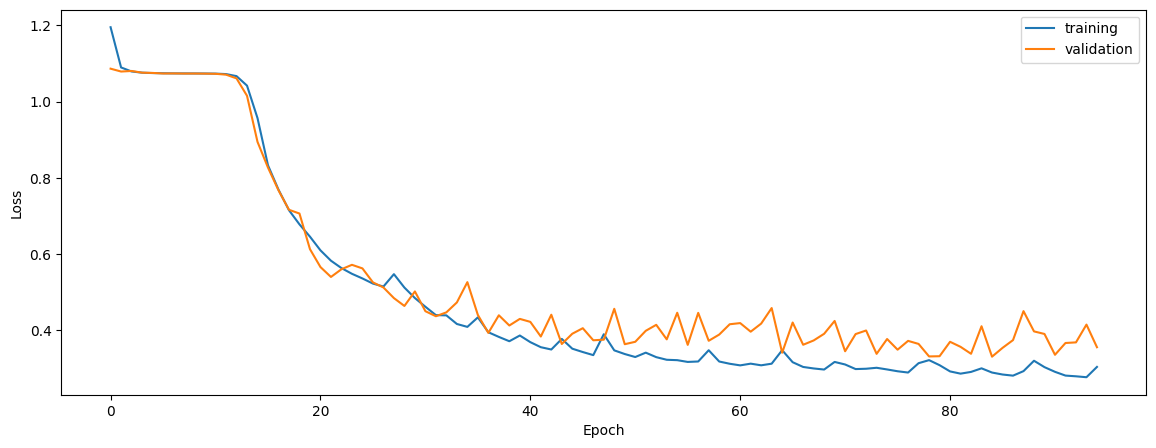

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.8913155538056966


0.8755306716669198


0.8698937509977474


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.9141491985203453


0.892358509841313


0.8875181589688012


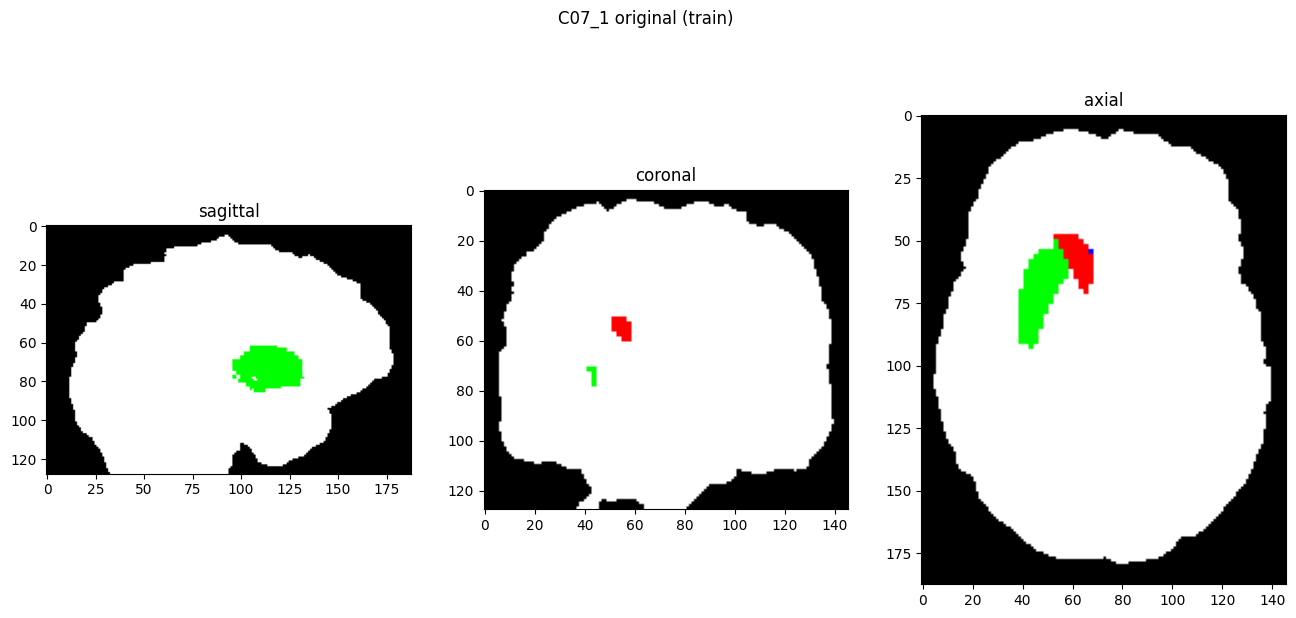

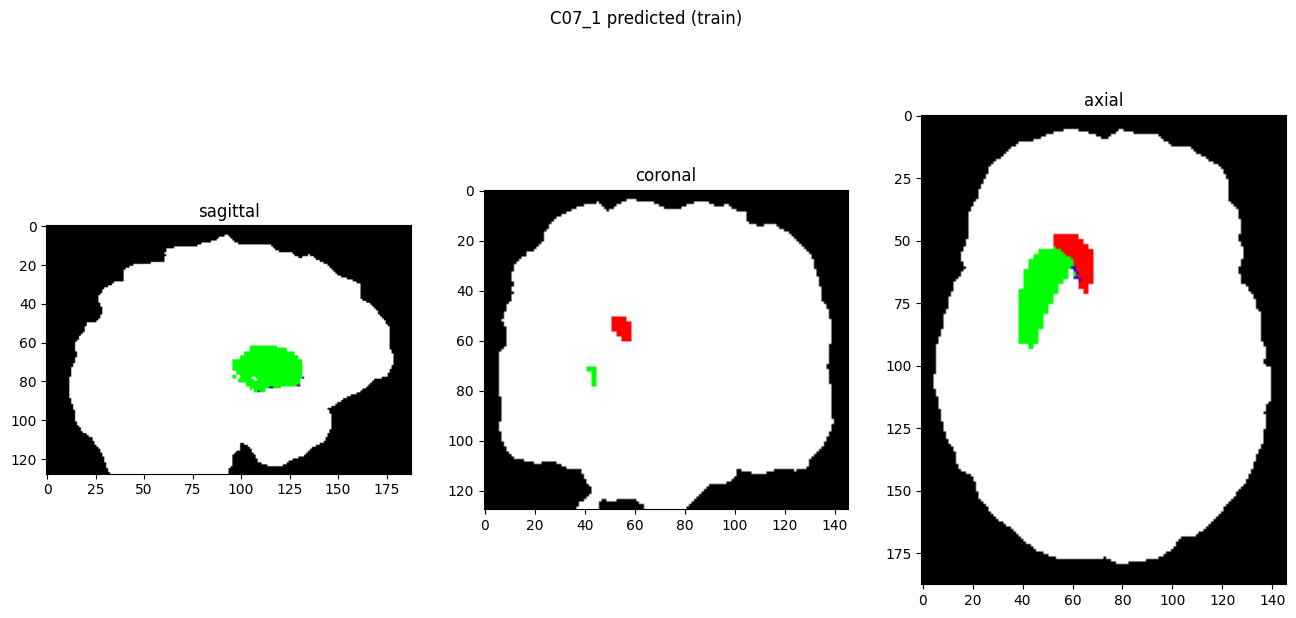

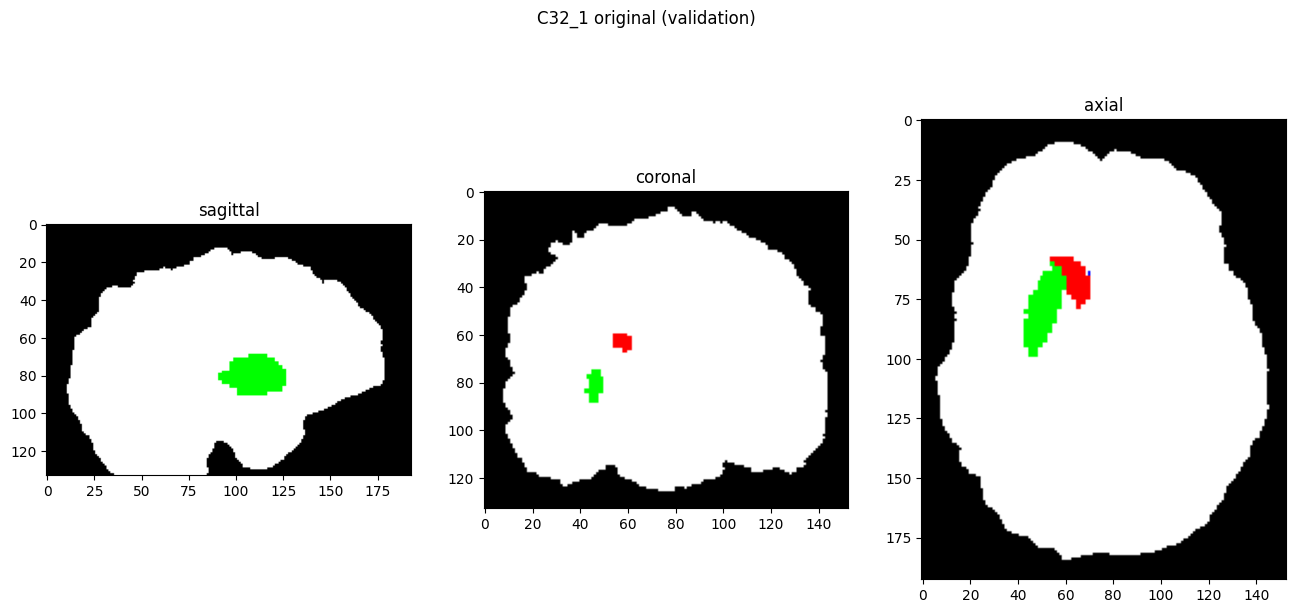

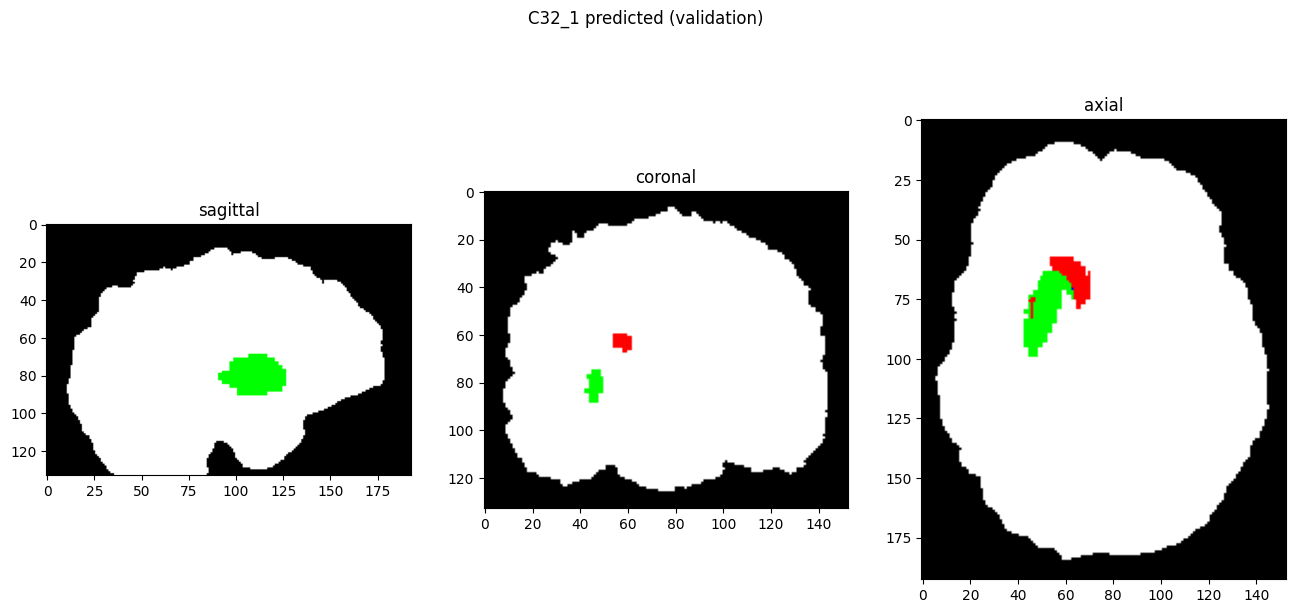

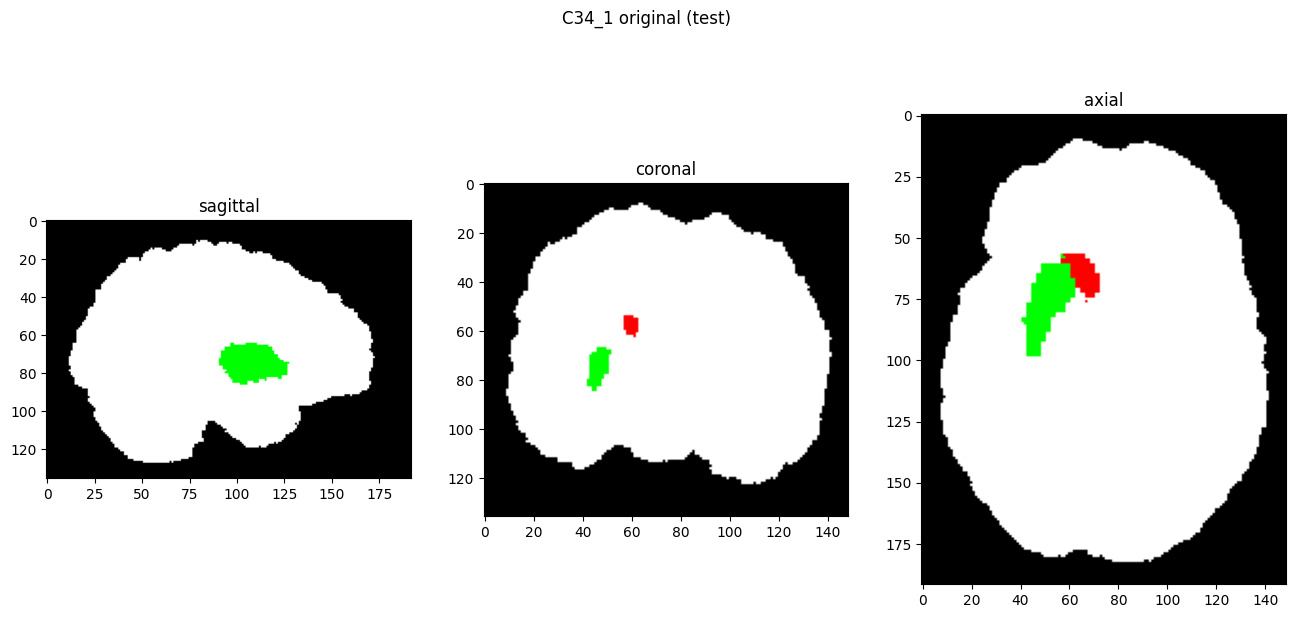

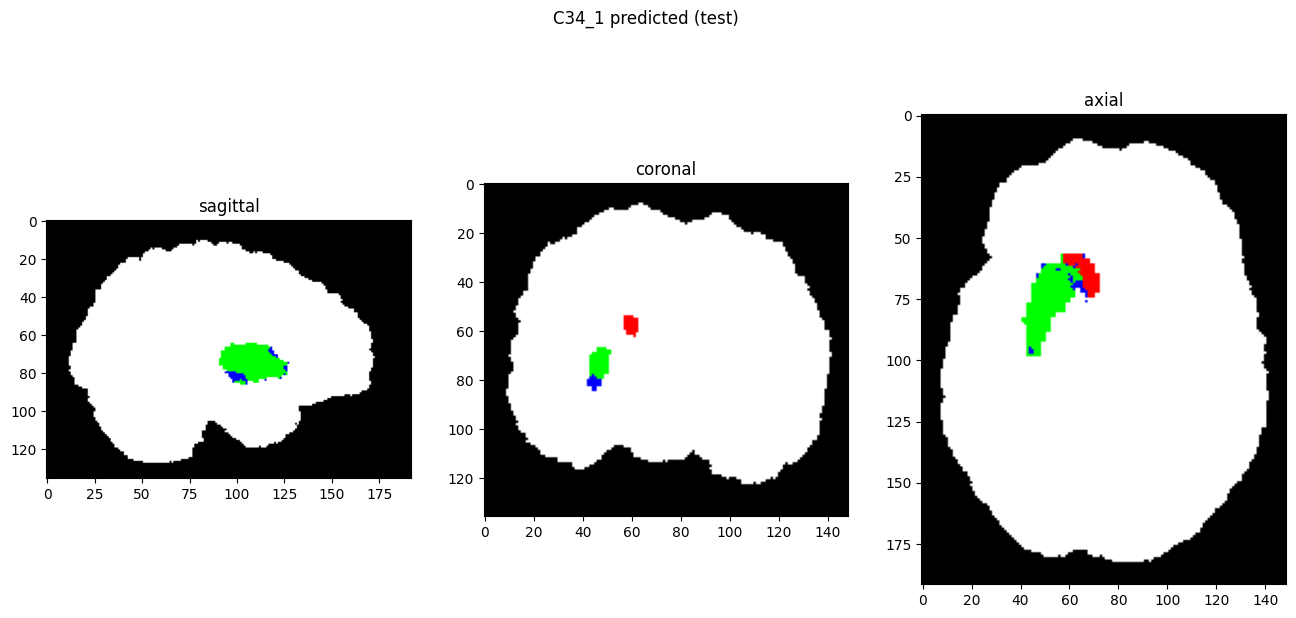

In [9]:
showResults(model, gen, threshold=0)